# **Préparation du dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from sklearn import preprocessing
from google.colab import drive

# Chemin du répertoire des images
path = '/content/drive/My Drive/Flipkart/Images'
drive.mount("/content/drive", force_remount=True)
list_photos = [file for file in listdir(path)]
print(len(list_photos))
print(list_photos)

Mounted at /content/drive
1050
['4c449766e715bc41023244c9042e0a82.jpg', '59d964c38c787f829c6cfa5629e4df90.jpg', '36b965559aa2b97cb961a603f18a9183.jpg', '98ad5b99ad96695568d8f143b11ab740.jpg', '51dc964c7a47293ff0ed0c6912813722.jpg', '7fd12776e6d62da6e1dd3cbc9882ee5f.jpg', 'd376da2235096f74600d842b6f5f2d1a.jpg', 'ab3f4b2d2ec007b7e0eaec213bfdbffc.jpg', '862c7462f12de819d93f93dc573289c5.jpg', '387ecd9ec173d61b6dc5ceddc079b150.jpg', 'c2e71e7c97489d4efa5eab796ae354ac.jpg', '215decf6f993d7b45d75520d9174493f.jpg', '8720a25546a572b0217817a82bfd00a5.jpg', '4fe24e100a5fcc33cf6054ef101067ed.jpg', '50be4cd92fda2755e1e884421a52e345.jpg', '726de30d1473ecb9641c1cd5286b6344.jpg', '07f8bdc4372a73d0820507683a936b6e.jpg', 'b1c7aa8e0f50e7ee73ed30d12af1a961.jpg', 'a231459c1562ee1117e95a61128820b7.jpg', 'ae19a81b730b48b87ca72521af8fb902.jpg', 'fa6f5eb34be4ad5daec225bfe09f2414.jpg', 'dbf7c443a45d684944b5d9928eef051f.jpg', 'a7a294ddbcd9bbbc46c034079529c17c.jpg', 'bd95002e0fea67f7ec2f2597814c5eaf.jpg', 'c6cd71c

In [3]:
data_cat_num = pd.read_csv('/content/drive/My Drive/Flipkart/data_cat_num.csv')
data_cat_num.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,label,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",4,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",0,Baby Care


In [4]:
from sklearn import preprocessing

data_photos = pd.DataFrame()
data_photos[['Image', 'Label_name', 'Label']] = data_cat_num[['image', 'product_category', 'label']]
data_photos

,Image,Label_name,Label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [5]:
data_grp= data_photos.groupby(["Label_name","Label"]).count()
data_grp

,,Image
Label_name,Label,
Baby Care,0,150
Beauty and Personal Care,1,150
Computers,2,150
Home Decor & Festive Needs,3,150
Home Furnishing,4,150
Kitchen & Dining,5,150
Watches,6,150


In [6]:
data_photos.to_csv('/content/drive/My Drive/Flipkart/pictures_data.csv', index=False)

In [7]:
from PIL import Image
import os

# Dossier de destination pour les images redimensionnées
output_path = "chemin_vers_le_dossier_de_destination"

# Vérifier si le dossier de destination existe, sinon le créer
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Parcourir les images et les redimensionner
for i, image_name in enumerate( path +'/' +data_photos['Image']):
    image_path = os.path.join(path, image_name)
    output_image_path = os.path.join(output_path, image_name)

    # Ouvrir l'image avec PIL
    image = Image.open(image_path)

    # Redimensionner l'image à la taille souhaitée (par exemple, 224x224)
    resized_image = image.resize((224, 224))

    # Enregistrer l'image redimensionnée dans le dossier de destination
    resized_image.save(output_image_path)

    # Afficher la progression
    #print("Image", i+1, "/", len(data_photos['Image']), "redimensionnée")

print("Redimensionnement terminé.")


Redimensionnement terminé.


In [8]:
list_labels = data_photos['Label_name'].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

Home Furnishing
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224


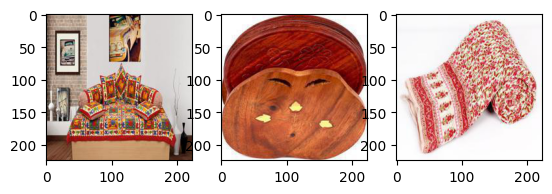

Baby Care
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224


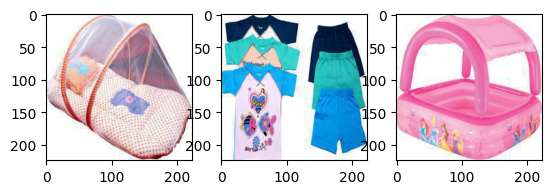

Watches
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224


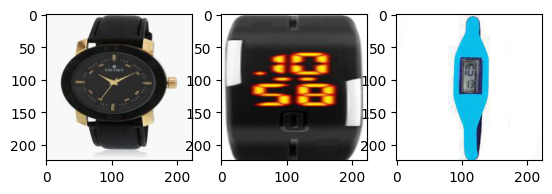

Home Decor & Festive Needs
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224


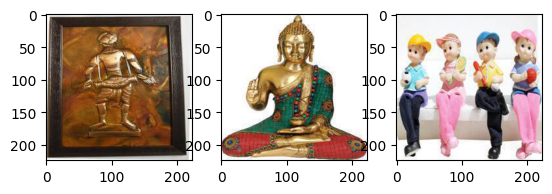

Kitchen & Dining
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224


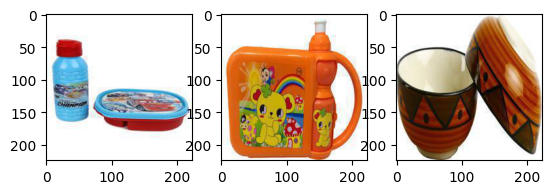

Beauty and Personal Care
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224


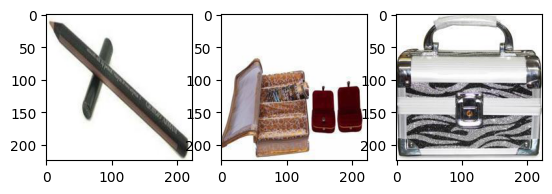

Computers
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224
Largeur : 224
Hauteur : 224


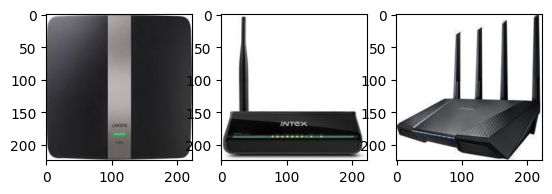

In [9]:
from matplotlib.image import imread

for label in list_labels:
    print(label)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + '/' + data_photos.loc[data_photos['Label_name'] == label, 'Image'].tolist()[i+10]
        image = imread(filename)
        plt.imshow(image)
         # Vérifier la taille de l'image
        height, width, _ = image.shape
        print("Largeur :", width)
        print("Hauteur :", height)
        plt.savefig('/content/drive/My Drive/Flipkart/Images-Cat.png')
    plt.show()

## Détermination et affichage des descripteurs SIFT

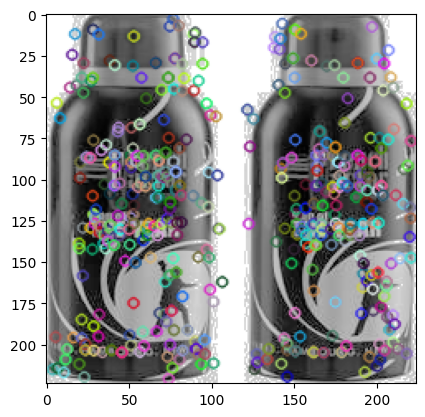

Largeur : 224
Hauteur : 224
Descripteurs : (462, 128)

[[131.  15.   0. ...   0.   0.   0.]
 [127.  11.   0. ...   0.   0.   0.]
 [ 62.  37.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   2. ...   0.   0.  21.]
 [  0.   0.   0. ...  18.   1.  12.]
 [ 13.  15.   1. ...   0.   0.   1.]]


In [29]:
import cv2

# Charger l'image en niveaux de gris
image_gray = cv2.imread(path + '/' + list_photos[1], 0)

# Égaliser l'histogramme de l'image
image_equalized = cv2.equalizeHist(image_gray)

# Créer l'objet SIFT
#sift = cv2.xfeatures2d.SIFT_create()  # Utilisation de cv2.xfeatures2d.SIFT_create() pour les anciennes versions de OpenCV
# Ou
sift = cv2.SIFT_create()  # Utilisation de cv2.SIFT_create() pour les versions plus récentes de OpenCV

# Détecter et calculer les descripteurs SIFT
kp, des = sift.detectAndCompute(image_equalized, None)

# Dessiner les keypoints sur l'image
img = cv2.drawKeypoints(image_equalized, kp, image_equalized)

# Afficher l'image avec les keypoints
plt.imshow(img)
plt.savefig('/content/drive/My Drive/Flipkart/Sift-keypoints.png')
plt.show()

# Obtenir la taille de l'image originale en niveaux de gris
hauteur, largeur = image_gray.shape

# Afficher la taille et les descripteurs
print("Largeur :", largeur)
print("Hauteur :", hauteur)
print("Descripteurs :", des.shape)
print()
print(des)


# Pré-traitement des images via SIFT
* Pour chaque image passage en gris et equalisation
* Création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisé pour réaliser les histogrammes par image
* Création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [11]:
!pip install opencv-python --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


In [12]:
!pip install opencv-contrib-python

In [13]:
import cv2
print(cv2.__version__)

4.7.0


In [14]:
import time

sift_keypoints = []
temps1 = time.time()
sift = cv2.SIFT_create(500)  # Utilisation de cv2.SIFT_create() pour la version 4.8.0

for photo_num, photo_name in enumerate(list_photos):
    if photo_num % 100 == 0:
        print(f"Traitement de la photo {photo_num + 1}/{len(list_photos)}")

    resized_image_path = path + '/' + photo_name  # Modifier le chemin vers les images redimensionnées
    image = cv2.imread(resized_image_path, 0)  # Convertir en niveaux de gris
    res = cv2.equalizeHist(image)  # Égaliser l'histogramme de l'image
    kp, des = sift.detectAndCompute(res, None)
    print("Dimension de des :", des.shape)

    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs :", sift_keypoints_all.shape)

duration1 = time.time() - temps1
print("Temps de traitement SIFT descriptor :", "%15.2f" % duration1, "secondes")


Traitement de la photo 1/1050
Dimension de des : (285, 128)
Dimension de des : (462, 128)
Dimension de des : (182, 128)
Dimension de des : (218, 128)
Dimension de des : (425, 128)
Dimension de des : (445, 128)
Dimension de des : (387, 128)
Dimension de des : (500, 128)
Dimension de des : (501, 128)
Dimension de des : (301, 128)
Dimension de des : (314, 128)
Dimension de des : (335, 128)
Dimension de des : (303, 128)
Dimension de des : (160, 128)
Dimension de des : (341, 128)
Dimension de des : (169, 128)
Dimension de des : (299, 128)
Dimension de des : (184, 128)
Dimension de des : (285, 128)
Dimension de des : (164, 128)
Dimension de des : (294, 128)
Dimension de des : (181, 128)
Dimension de des : (500, 128)
Dimension de des : (211, 128)
Dimension de des : (476, 128)
Dimension de des : (500, 128)
Dimension de des : (392, 128)
Dimension de des : (114, 128)
Dimension de des : (428, 128)
Dimension de des : (81, 128)
Dimension de des : (457, 128)
Dimension de des : (287, 128)
Dimension d

<ipython-input-14-077cd0f87f29>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [15]:
from sklearn import cluster, metrics

# Determination number of clusters
T_1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")


# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0, n_init=3)
kmeans.fit(sift_keypoints_all)

T_2=time.time()-T_1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  591
Création de 591 clusters de descripteurs ...
temps de traitement kmeans :            37.73 secondes


## Création des features des images
* Pour chaque image :
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [16]:
# Creation of histograms (features)
T_1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

T_2=time.time()-T_1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            37.73 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [17]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 591)
Dimensions dataset après réduction PCA :  (1050, 487)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [18]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)


df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = None

for i, image_name in enumerate(path + '/'+ data_photos['Image']):
    resized_image_path = os.path.join(output_path, image_name)  # Chemin vers les images redimensionnées
    df_tsne.at[i, "class"] = cv2.imread(resized_image_path)

print(df_tsne.shape)

(1050, 3)


In [19]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_photos["Label_name"]  # Utilisez les étiquettes de classe réelles

print(df_tsne.shape)


(1050, 3)


In [20]:
df_tsne.head(3)

,tsne1,tsne2,class
0,15.051360,3.946728,Home Furnishing
1,13.243544,6.966797,Baby Care
2,7.336322,15.473730,Baby Care


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "..." et "..." sont partiellement séparées

<ipython-input-21-16bc7e0f7b54>:2: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",


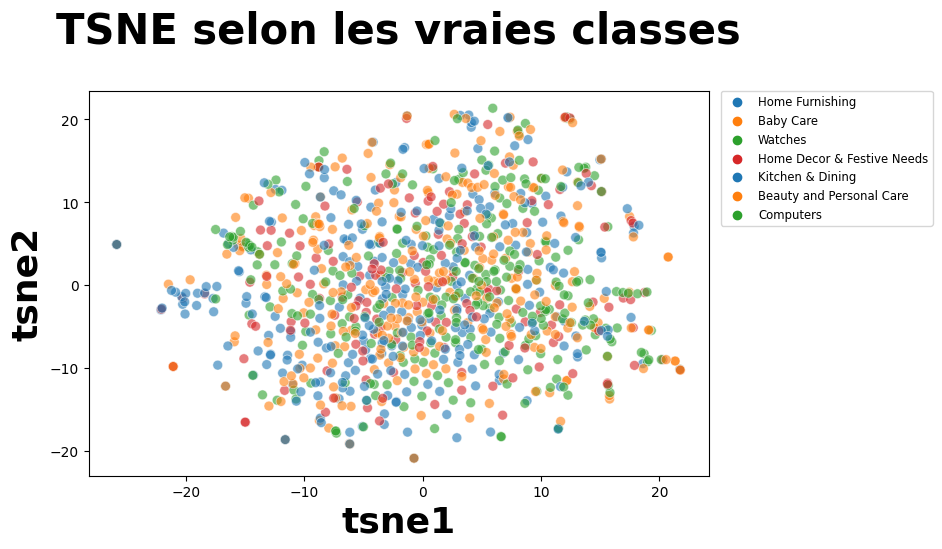

In [21]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})
# Réduire la taille de l'encadré de la légende
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='small')
plt.savefig('/content/drive/My Drive/Flipkart/Sift-Vcat-plot.png')
plt.show()

## Analyse mesures : similarité entre catégories et **clusters**

### Création de clusters à partir du T-SNE

In [22]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters


<ipython-input-23-5b7aed19d7f9>:2: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


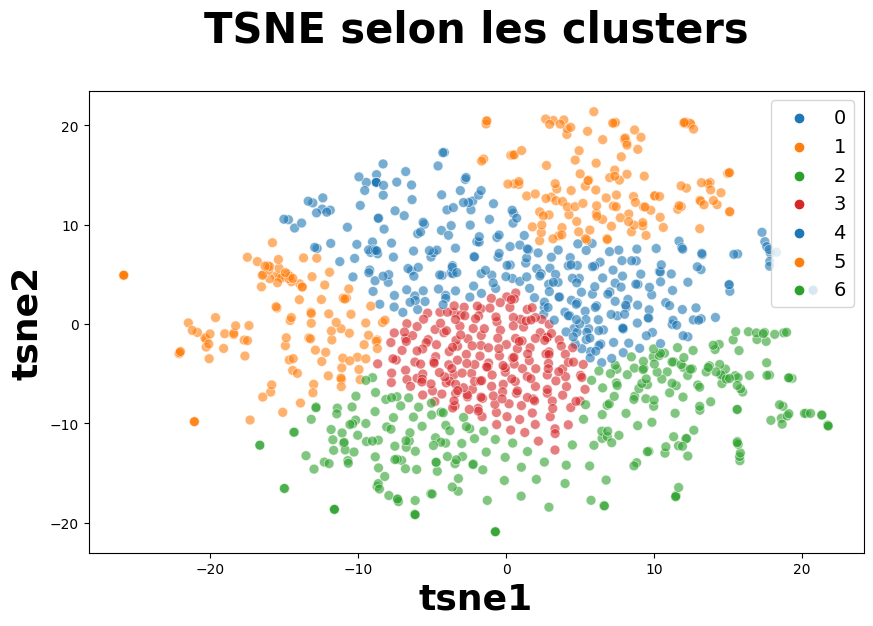

ARI :  0.006791782212349268


In [23]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})
plt.savefig('/content/drive/My Drive/Flipkart/Sift-Clusters-plot.png')
plt.show()

labels = data_photos["Label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
# * Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")

In [24]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    147
1    136
2    153
3    212
4    154
5    123
6    125
Name: class, dtype: int64

In [25]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[17 24 18 35 26 12 18]
 [32 18 22 27 21 16 14]
 [19 20 24 32 21 20 14]
 [22 18 25 36 16 19 14]
 [19 15 11 32 20 18 35]
 [24 22 15 27 15 26 21]
 [14 19 38 23 35 12  9]]


In [26]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [6,5,4,3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
#conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
#print(conf_mat)
#print()
#print(metrics.classification_report(labels, cls_labels_transform))
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform, zero_division=1))


Correspondance des clusters :  [6, 5, 4, 3, 1, 2, 0]
[[18 26 12 35 18 24 17]
 [14 21 16 27 22 18 32]
 [14 21 20 32 24 20 19]
 [14 16 19 36 25 18 22]
 [35 20 18 32 11 15 19]
 [21 15 26 27 15 22 24]
 [ 9 35 12 23 38 19 14]]

              precision    recall  f1-score   support

           0       0.14      0.12      0.13       150
           1       0.14      0.14      0.14       150
           2       0.16      0.13      0.15       150
           3       0.17      0.24      0.20       150
           4       0.07      0.07      0.07       150
           5       0.16      0.15      0.15       150
           6       0.10      0.09      0.09       150

    accuracy                           0.14      1050
   macro avg       0.13      0.14      0.13      1050
weighted avg       0.13      0.14      0.13      1050



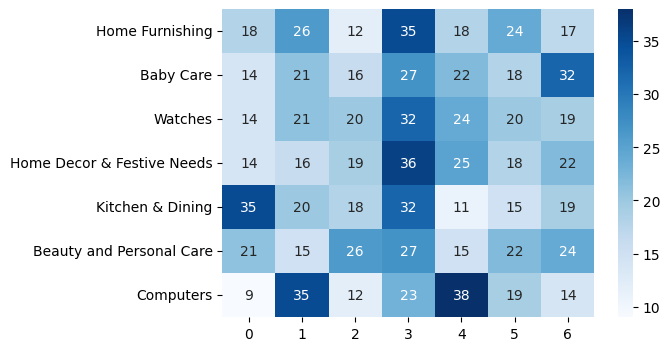

In [28]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.savefig('/content/drive/My Drive/Flipkart/cm-sift.png')